# 1. Parameters

In [1]:
metadata_file = 'input/metadata.tsv.gz'
input_sequences = 'input/sequences.fasta.xz'
sequences_split_dir = 'input/split'
sequences_subset_all = 'input/all.fasta.gz'
subset_input_files_path = 'input/input-files.tsv'
subset_metadata_path = 'input/metadata-subsample.tsv'

subsample_number = 100000

# I can handle any amount of missing data in my index but building trees with iqtree starts to fail 
# when there is too much missing data so I'm limiting it here.
max_missing_percent = 50

sample_seed = 21561

In [2]:
from pathlib import Path

metadata_file = Path(metadata_file)
input_sequences = Path(input_sequences)
sequences_split_dir = Path(sequences_split_dir)
subset_input_files_path = Path(subset_input_files_path)
subset_metadata_path = Path(subset_metadata_path)
sequences_subset_all = Path(sequences_subset_all)

# 2. Load metadata

In [3]:
import pandas as pd

metadata_all_df = pd.read_csv(metadata_file, sep='\t')
metadata_all_df

/tmp/ipykernel_41099/3816968743.py:3: DtypeWarning: Columns (4,9,45,50) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata_all_df = pd.read_csv(metadata_file, sep='\t')


,strain,virus,gisaid_epi_isl,genbank_accession,sra_accession,date,region,country,division,location,...,QC_frame_shifts,QC_stop_codons,QC_overall_score,QC_overall_status,frame_shifts,deletions,insertions,substitutions,aaSubstitutions,clock_deviation
0,?,ncov,EPI_ISL_8303487,OV377246,ERR7904006,?,Europe,United Kingdom,?,NaN,...,good,good,4378.330003,bad,NaN,6513-6515,"22195:NTAGTGCGT,25695:GAA","C241T,A2832G,C3037T,C7124T,G8393A,G9441T,C1002...","M:I82T,ORF1a:K856R,ORF1a:L2084I,ORF1a:P2287S,O...",?
1,ARG/210316-1/2021,ncov,?,OL989073,NaN,2021-03-15,South America,Argentina,Argentina,NaN,...,good,good,8.506944,good,NaN,NaN,NaN,"C66T,C241T,C3037T,A4926G,A5574G,C7564A,C8139T,...","N:R203K,N:G204R,ORF1a:D1554G,ORF1a:Y1770C,ORF1...",2.0
2,ARG/210524-2/2021,ncov,?,OL989092,NaN,2021-05-17,South America,Argentina,Argentina,NaN,...,good,good,2.777778,good,NaN,NaN,NaN,"A22G,C241T,C913T,C3037T,C3177T,C3267T,C5388A,C...","N:D3L,N:R203K,N:G204R,N:S235F,N:A308S,ORF1a:P9...",3.0
3,ARG/210610-225/2021,ncov,?,OL989093,NaN,2021-06-07,South America,Argentina,Argentina,NaN,...,good,good,44.444444,mediocre,NaN,NaN,NaN,"C241T,C913T,A1967G,C3037T,C3177T,C3267T,C5388A...","N:D3L,N:P151L,N:R203K,N:G204R,N:S235F,ORF1a:T5...",0.0
4,ARG/210613-39/2021,ncov,?,OL989084,NaN,2021-06-07,South America,Argentina,Argentina,NaN,...,good,good,6.250000,good,NaN,NaN,NaN,"C241T,T733C,A2596G,C2749T,C3037T,C3828T,A5648C...","M:H125Y,N:P80R,N:R203K,N:G204R,ORF1a:S1188L,OR...",0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6210950,mink/USA/WI-CDC-3892928-001/2020,ncov,EPI_ISL_1014952,MW626383,NaN,2020-10-15,North America,USA,USA,NaN,...,good,good,25.000000,good,NaN,29816-29821,NaN,"C241T,C1059T,C3037T,A5877G,A10875G,T11968C,C14...","N:S194L,N:K355N,ORF1a:T265I,ORF1a:N1871S,ORF1a...",-1.0
6210951,mink/USA/WI-CDC-3892938-001/2020,ncov,EPI_ISL_1014953,MW626384,NaN,2020-10-15,North America,USA,USA,NaN,...,good,good,39.062500,mediocre,NaN,29816-29821,NaN,"C241T,C1059T,C2675T,C3037T,A5877G,A10875G,T119...","N:S194L,N:K355N,ORF1a:T265I,ORF1a:P804S,ORF1a:...",1.0
6210952,mouse/CHN/MP7/2021,ncov,?,OM062573,NaN,2021-05-01,Asia,China,Beijing,NaN,...,good,good,2.777778,good,NaN,"11288-11296,22283-22291",NaN,"T3C,G174T,C241T,C1059T,A2692T,C3037T,C3817T,C3...","E:T30I,E:P71L,N:T205I,ORF1a:T265I,ORF1a:P1220L...",0.0
6210953,mouse/Japan/MA-P10/2022,ncov,?,LC716263,NaN,2022-06-17,Asia,Japan,Hokkaido,NaN,...,good,good,2.777778,good,NaN,NaN,NaN,"C2662T,C8782T,C9924T,A10863G,G12801A,A21137G,A...","N:T205I,ORF1a:A3220V,ORF1a:E3533G,ORF1a:R4179K...",-43.0


In [4]:
metadata_all_df.columns

Index(['strain', 'virus', 'gisaid_epi_isl', 'genbank_accession',
       'sra_accession', 'date', 'region', 'country', 'division', 'location',
       'region_exposure', 'country_exposure', 'division_exposure', 'segment',
       'length', 'host', 'age', 'sex', 'Nextstrain_clade', 'pango_lineage',
       'GISAID_clade', 'originating_lab', 'submitting_lab', 'authors', 'url',
       'title', 'paper_url', 'date_submitted', 'sampling_strategy',
       'Nextclade_pango', 'missing_data', 'divergence', 'nonACGTN', 'coverage',
       'rare_mutations', 'reversion_mutations', 'potential_contaminants',
       'QC_missing_data', 'QC_mixed_sites', 'QC_rare_mutations',
       'QC_snp_clusters', 'QC_frame_shifts', 'QC_stop_codons',
       'QC_overall_score', 'QC_overall_status', 'frame_shifts', 'deletions',
       'insertions', 'substitutions', 'aaSubstitutions', 'clock_deviation'],
      dtype='object')

## 2.1. Remove sequences with too high of missing data

<AxesSubplot: >

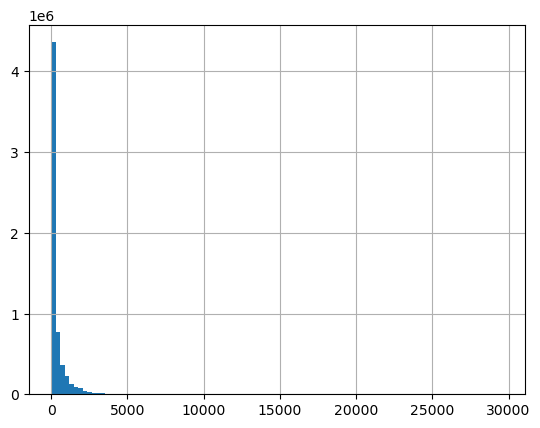

In [5]:
metadata_all_df['missing_data'].hist(bins=100)

<AxesSubplot: >

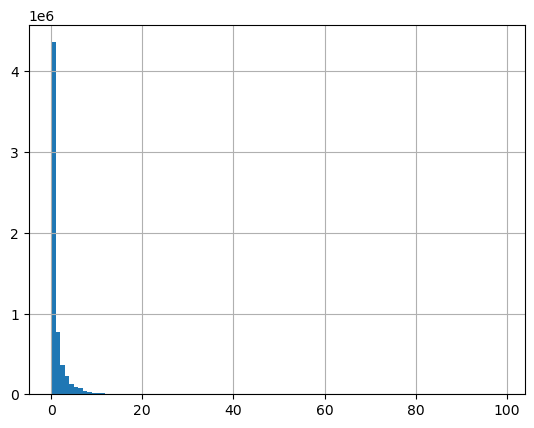

In [6]:
metadata_all_df['missing_data_percent'] = 100 * (metadata_all_df['missing_data'] / 29903)
metadata_all_df['missing_data_percent'].hist(bins=100)

In [7]:
metadata_all_df = metadata_all_df[metadata_all_df['missing_data_percent'] < max_missing_percent]
metadata_all_df

,strain,virus,gisaid_epi_isl,genbank_accession,sra_accession,date,region,country,division,location,...,QC_stop_codons,QC_overall_score,QC_overall_status,frame_shifts,deletions,insertions,substitutions,aaSubstitutions,clock_deviation,missing_data_percent
0,?,ncov,EPI_ISL_8303487,OV377246,ERR7904006,?,Europe,United Kingdom,?,NaN,...,good,4378.330003,bad,NaN,6513-6515,"22195:NTAGTGCGT,25695:GAA","C241T,A2832G,C3037T,C7124T,G8393A,G9441T,C1002...","M:I82T,ORF1a:K856R,ORF1a:L2084I,ORF1a:P2287S,O...",?,9.534160
1,ARG/210316-1/2021,ncov,?,OL989073,NaN,2021-03-15,South America,Argentina,Argentina,NaN,...,good,8.506944,good,NaN,NaN,NaN,"C66T,C241T,C3037T,A4926G,A5574G,C7564A,C8139T,...","N:R203K,N:G204R,ORF1a:D1554G,ORF1a:Y1770C,ORF1...",2.0,0.063539
2,ARG/210524-2/2021,ncov,?,OL989092,NaN,2021-05-17,South America,Argentina,Argentina,NaN,...,good,2.777778,good,NaN,NaN,NaN,"A22G,C241T,C913T,C3037T,C3177T,C3267T,C5388A,C...","N:D3L,N:R203K,N:G204R,N:S235F,N:A308S,ORF1a:P9...",3.0,0.852757
3,ARG/210610-225/2021,ncov,?,OL989093,NaN,2021-06-07,South America,Argentina,Argentina,NaN,...,good,44.444444,mediocre,NaN,NaN,NaN,"C241T,C913T,A1967G,C3037T,C3177T,C3267T,C5388A...","N:D3L,N:P151L,N:R203K,N:G204R,N:S235F,ORF1a:T5...",0.0,0.648764
4,ARG/210613-39/2021,ncov,?,OL989084,NaN,2021-06-07,South America,Argentina,Argentina,NaN,...,good,6.250000,good,NaN,NaN,NaN,"C241T,T733C,A2596G,C2749T,C3037T,C3828T,A5648C...","M:H125Y,N:P80R,N:R203K,N:G204R,ORF1a:S1188L,OR...",0.0,0.033441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6210950,mink/USA/WI-CDC-3892928-001/2020,ncov,EPI_ISL_1014952,MW626383,NaN,2020-10-15,North America,USA,USA,NaN,...,good,25.000000,good,NaN,29816-29821,NaN,"C241T,C1059T,C3037T,A5877G,A10875G,T11968C,C14...","N:S194L,N:K355N,ORF1a:T265I,ORF1a:N1871S,ORF1a...",-1.0,0.000000
6210951,mink/USA/WI-CDC-3892938-001/2020,ncov,EPI_ISL_1014953,MW626384,NaN,2020-10-15,North America,USA,USA,NaN,...,good,39.062500,mediocre,NaN,29816-29821,NaN,"C241T,C1059T,C2675T,C3037T,A5877G,A10875G,T119...","N:S194L,N:K355N,ORF1a:T265I,ORF1a:P804S,ORF1a:...",1.0,0.000000
6210952,mouse/CHN/MP7/2021,ncov,?,OM062573,NaN,2021-05-01,Asia,China,Beijing,NaN,...,good,2.777778,good,NaN,"11288-11296,22283-22291",NaN,"T3C,G174T,C241T,C1059T,A2692T,C3037T,C3817T,C3...","E:T30I,E:P71L,N:T205I,ORF1a:T265I,ORF1a:P1220L...",0.0,0.000000
6210953,mouse/Japan/MA-P10/2022,ncov,?,LC716263,NaN,2022-06-17,Asia,Japan,Hokkaido,NaN,...,good,2.777778,good,NaN,NaN,NaN,"C2662T,C8782T,C9924T,A10863G,G12801A,A21137G,A...","N:T205I,ORF1a:A3220V,ORF1a:E3533G,ORF1a:R4179K...",-43.0,0.000000


## 2.2. Look for duplicates in table

In [8]:
len_all = len(metadata_all_df)
len_no_duplicates = metadata_all_df['strain'].agg('count')
if len_all == len_no_duplicates:
    print(f'No duplicates: len_all={len_all} == len_no_duplicates={len_no_duplicates}')
else:
    print(f'Some duplicates found: len_all={len_all} == len_no_duplicates={len_no_duplicates}')

No duplicates: len_all=6210266 == len_no_duplicates=6210266


## 2.3. Subsample dataframe

In [9]:
metadata_df = metadata_all_df.sample(subsample_number, random_state=sample_seed)
metadata_df

,strain,virus,gisaid_epi_isl,genbank_accession,sra_accession,date,region,country,division,location,...,QC_stop_codons,QC_overall_score,QC_overall_status,frame_shifts,deletions,insertions,substitutions,aaSubstitutions,clock_deviation,missing_data_percent
3202072,Scotland/QEUH-3DF3D03/2022,ncov,EPI_ISL_12630193,OW855487,ERR9720965,2022-05-03,Europe,United Kingdom,Scotland,NaN,...,good,0.000000,good,NaN,"11288-11296,21633-21641,28362-28370,29734-29759",NaN,"C241T,T670G,G1857T,C2790T,C3037T,G4184A,C4321T...","E:T9I,M:Q19E,M:A63T,N:P13L,N:R203K,N:G204R,N:S...",2.0,0.421362
249200,Denmark/DCGC-384569/2022,ncov,EPI_ISL_10258944,OX022835,ERS12093125,2022-02-15,Europe,Denmark,Syddanmark,NaN,...,good,0.000000,good,NaN,"509-523,11288-11296,21633-21641,28362-28370",NaN,"C241T,T670G,C2790T,C3037T,G4184A,C4321T,C9344T...","E:T9I,M:Q19E,M:A63T,N:P13L,N:R203K,N:G204R,N:S...",5.0,0.404642
2654252,OW500387,ncov,?,OW500387,ERS11571025,2022-01-17,Europe,United Kingdom,United Kingdom,NaN,...,good,3.666516,good,NaN,"6513-6515,11285-11293,21765-21770,21987-21995,...",22204:GAGCCAGAA,"C241T,A2832G,C3037T,C3241T,T5386G,G5924A,G8393...","E:T9I,M:D3G,M:Q19E,M:A63T,N:P13L,N:R203K,N:G20...",-3.0,2.732167
5611444,USA/TG1138574/2022,ncov,EPI_ISL_8874412,ON541191,SRR19475243,2022-01-03,North America,USA,Arizona,Pima County,...,good,1.623265,good,NaN,"6513-6515,11285-11293,21765-21770,21987-21995,...",22204:GAGCCAGAA,"C241T,A1992G,A2832G,C3037T,T5386G,G8393A,C1002...","E:T9I,M:D3G,M:A63T,N:P13L,N:R203K,N:G204R,N:D3...",0.0,2.153630
5678912,USA/TX-CDC-ASC210194138/2021,ncov,EPI_ISL_5230152,OK406723,NaN,2021-08-20,North America,USA,Texas,NaN,...,good,6.250000,good,NaN,"22029-22034,28248-28253,28271",NaN,"G210T,T224C,C241T,C1218T,C3037T,G4181T,C6402T,...","M:I82T,N:D63G,N:R203M,N:G215C,N:D377Y,ORF1a:S3...",3.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3302832,Switzerland/SO-ETHZ-561547/2020,ncov,EPI_ISL_1598444,OU190135,ERS6825234,2021-03-29,Europe,Switzerland,Solothurn,NaN,...,good,0.000000,good,NaN,"11288-11296,21765-21770,21992-21994,28271",NaN,"C241T,C913T,C3037T,C3267T,A4964G,C5388A,C5986T...","N:D3L,N:R203K,N:G204R,N:S235F,ORF1a:T1001I,ORF...",0.0,0.030097
426763,Denmark/DCGC-569733/2022,ncov,?,OX329283,ERS13409574,2022-08-18,Europe,Denmark,Midtjylland,NaN,...,good,26.361111,good,NaN,"11288-11296,21633-21641,21765-21770,28362-28370",NaN,"C241T,T670G,C1627T,C2790T,C3037T,C3294T,T3324C...","E:T9I,M:A63T,N:P13L,N:R95C,N:R203K,N:G204R,N:S...",0.0,0.458148
1638010,England/MILK-3A04FDF/2022,ncov,EPI_ISL_11078341,OW210645,ERR9333689,2022-03-09,Europe,United Kingdom,England,NaN,...,good,0.000000,good,NaN,"11288-11296,21633-21641,28362-28370,29734-29759",NaN,"C241T,T670G,C2790T,C3037T,G4184A,C4321T,C9344T...","E:T9I,M:Q19E,M:A63T,N:P13L,N:R203K,N:G204R,N:S...",0.0,0.421362
788242,England/ALDP-B5CC7F/2020,ncov,EPI_ISL_655902,OB997493,ERR4973707,2020-11-08,Europe,United Kingdom,England,NaN,...,good,0.000000,good,NaN,NaN,NaN,"C66T,C241T,T445C,A1987G,C3037T,G4187A,C6286T,C...","N:A220V,ORF1a:G1308S,ORF1a:K3839R,ORF1b:P314L,...",3.0,0.404642


# 3. Extract sequences to separate files and prepare dataframe

In [10]:
from Bio import SeqIO
from pathlib import Path
from os import mkdir
import lzma
import gzip
import shutil
import time

total = len(metadata_all_df)

if sequences_split_dir.exists():
    shutil.rmtree(sequences_split_dir)

if not sequences_split_dir.exists():
    mkdir(sequences_split_dir)
    
included_samples = set(metadata_df['strain'].tolist())

print_on = 20000

time_before = time.time()
count = 0
input_file_data = []
with lzma.open(input_sequences, 'tr') as ih:
    with gzip.open(sequences_subset_all, "wt") as all_h:
        for record in SeqIO.parse(ih, 'fasta'):
            if count % print_on == 0:
                percent = (count/total) * 100
                print(f'{count}')

            name = record.id
            if name in included_samples:
                cleaned_name = name.replace('/', '__')
                out_file_path = (sequences_split_dir / f'{cleaned_name}.fasta.gz').absolute()
                input_file_data.append([name, str(out_file_path), pd.NA, pd.NA])
                with gzip.open(out_file_path, "wt") as oh:
                    SeqIO.write(record, oh, "fasta")
                    
                # Write to all file
                SeqIO.write(record, all_h, "fasta")

            count += 1

input_file_df = pd.DataFrame(input_file_data, columns=['Sample', 'Assemblies', 'Reads1', 'Reads2'])
time_after = time.time()
print(f'Finished writing files to {sequences_split_dir}.')
print(f'Took {(time_after - time_before)/60:0.1f} minutes')
input_file_df.head(5)

0
20000
40000
60000
80000
100000
120000
140000
160000
180000
200000
220000
240000
260000
280000
300000
320000
340000
360000
380000
400000
420000
440000
460000
480000
500000
520000
540000
560000
580000
600000
620000
640000
660000
680000
700000
720000
740000
760000
780000
800000
820000
840000
860000
880000
900000
920000
940000
960000
980000
1000000
1020000
1040000
1060000
1080000
1100000
1120000
1140000
1160000
1180000
1200000
1220000
1240000
1260000
1280000
1300000
1320000
1340000
1360000
1380000
1400000
1420000
1440000
1460000
1480000
1500000
1520000
1540000
1560000
1580000
1600000
1620000
1640000
1660000
1680000
1700000
1720000
1740000
1760000
1780000
1800000
1820000
1840000
1860000
1880000
1900000
1920000
1940000
1960000
1980000
2000000
2020000
2040000
2060000
2080000
2100000
2120000
2140000
2160000
2180000
2200000
2220000
2240000
2260000
2280000
2300000
2320000
2340000
2360000
2380000
2400000
2420000
2440000
2460000
2480000
2500000
2520000
2540000
2560000
2580000
2600000
2620000
264

,Sample,Assemblies,Reads1,Reads2
0,Switzerland/120005/2020,/home/CSCScience.ca/apetkau/workspace/genomics...,<NA>,<NA>
1,Switzerland/120040/2020,/home/CSCScience.ca/apetkau/workspace/genomics...,<NA>,<NA>
2,Switzerland/100128/2020,/home/CSCScience.ca/apetkau/workspace/genomics...,<NA>,<NA>
3,Switzerland/100814/2020,/home/CSCScience.ca/apetkau/workspace/genomics...,<NA>,<NA>
4,Switzerland/101130/2020,/home/CSCScience.ca/apetkau/workspace/genomics...,<NA>,<NA>


## 3.1. Save input dataframe to file

In [24]:
input_file_df_ordered = input_file_df.set_index('Sample').loc[metadata_df['strain'].tolist()].reset_index()
input_file_df_ordered

,Sample,Assemblies,Reads1,Reads2
0,Scotland/QEUH-3DF3D03/2022,/home/CSCScience.ca/apetkau/workspace/genomics...,<NA>,<NA>
1,Denmark/DCGC-384569/2022,/home/CSCScience.ca/apetkau/workspace/genomics...,<NA>,<NA>
2,OW500387,/home/CSCScience.ca/apetkau/workspace/genomics...,<NA>,<NA>
3,USA/TG1138574/2022,/home/CSCScience.ca/apetkau/workspace/genomics...,<NA>,<NA>
4,USA/TX-CDC-ASC210194138/2021,/home/CSCScience.ca/apetkau/workspace/genomics...,<NA>,<NA>
...,...,...,...,...
99995,Switzerland/SO-ETHZ-561547/2020,/home/CSCScience.ca/apetkau/workspace/genomics...,<NA>,<NA>
99996,Denmark/DCGC-569733/2022,/home/CSCScience.ca/apetkau/workspace/genomics...,<NA>,<NA>
99997,England/MILK-3A04FDF/2022,/home/CSCScience.ca/apetkau/workspace/genomics...,<NA>,<NA>
99998,England/ALDP-B5CC7F/2020,/home/CSCScience.ca/apetkau/workspace/genomics...,<NA>,<NA>


In [25]:
import numpy as np
import math
from os import remove

if subset_input_files_path.exists():
    remove(subset_input_files_path)

input_file_df_ordered.to_csv(subset_input_files_path, sep='\t', index=False)
    
print(f'Wrote input files to {subset_input_files_path}')

Wrote input files to input/input-files.tsv


In [26]:
input_file_df.head()

,Sample,Assemblies,Reads1,Reads2
0,Switzerland/120005/2020,/home/CSCScience.ca/apetkau/workspace/genomics...,<NA>,<NA>
1,Switzerland/120040/2020,/home/CSCScience.ca/apetkau/workspace/genomics...,<NA>,<NA>
2,Switzerland/100128/2020,/home/CSCScience.ca/apetkau/workspace/genomics...,<NA>,<NA>
3,Switzerland/100814/2020,/home/CSCScience.ca/apetkau/workspace/genomics...,<NA>,<NA>
4,Switzerland/101130/2020,/home/CSCScience.ca/apetkau/workspace/genomics...,<NA>,<NA>


## 3.1.2. Save subset metadata to file

In [27]:
metadata_df.to_csv(subset_metadata_path, sep='\t', index=False)

print(f'Wrote subset metadata to {subset_metadata_path}')

Wrote subset metadata to input/metadata-subsample.tsv
